### Python 3.8.10

In [ ]:
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import save_image

import unsplit.attacks as unsplit
from unsplit.models import *
from unsplit.util import *

import Optimizers as opt

import scipy



In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True
0
1


device(type='cuda')

In [3]:
split_layer = 2

In [53]:
dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

In [54]:
for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)

## Learning without noise

In [28]:
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.302849531173706 Acc: 20.394736842105264
Epoch: 1 Loss: 2.3002285957336426 Acc: 16.294277929155314
Epoch: 2 Loss: 2.297558546066284 Acc: 17.40801757276222
Epoch: 3 Loss: 2.2943904399871826 Acc: 18.954248366013072
Epoch: 4 Loss: 2.2903969287872314 Acc: 25.583982202447164
Epoch: 5 Loss: 2.2847559452056885 Acc: 30.925013683634372
Epoch: 6 Loss: 2.2757861614227295 Acc: 33.49726775956284
Epoch: 7 Loss: 2.2591288089752197 Acc: 38.121245221190605
Epoch: 8 Loss: 2.222214460372925 Acc: 43.67816091954023
Epoch: 9 Loss: 2.120591878890991 Acc: 46.44420131291029
Epoch: 10 Loss: 1.7785375118255615 Acc: 69.07103825136612
Epoch: 11 Loss: 1.1191990375518799 Acc: 78.82611080636313
Epoch: 12 Loss: 0.6969941258430481 Acc: 83.04061470911087
Epoch: 13 Loss: 0.5477314591407776 Acc: 86.81440443213296
Epoch: 14 Loss: 0.4752420485019684 Acc: 87.4451754385965
Epoch: 15 Loss: 0.427045613527298 Acc: 88.21271929824562
Epoch: 16 Loss: 0.3906811773777008 Acc: 88.94362342638205
Epoch: 17 Loss: 0.361325

## Learning with noise

In [55]:
import torch.distributions as dist

class CustomNormalDistribution(nn.Module):
    def __init__(self, shape, mean, std):
        super(CustomNormalDistribution, self).__init__()
        self.shape = shape
        self.mean = nn.Parameter(torch.tensor(mean))
        self.std = nn.Parameter(torch.tensor(std))

    def forward(self):
        return dist.Normal(self.mean, self.std)


def noisybatch(images, mean=0.0, std=1.0):
    shape = images.shape
    custom_dist = CustomNormalDistribution(shape, mean, std)
    sample = custom_dist().rsample()
    return sample

Find global $l2$-sensitivity 

In [56]:
total_batches = 0
summed_batch = None
for batch in trainloader:
    if summed_batch is None:
        summed_batch = torch.zeros_like(batch[0])
    if batch[0].size(0) == summed_batch.size(0):
        summed_batch += batch[0]
        total_batches += 1

averaged_batch = summed_batch / total_batches

averaged_batch_copy = averaged_batch.clone()
s = random.randint(0, 64)
averaged_batch_copy[s] = torch.zeros_like(averaged_batch_copy[s])
gs = torch.norm(averaged_batch - averaged_batch_copy, p='fro').float()
print(gs)

tensor(5.8791)


Now let us adjust distribution parameter $\sigma$ for $(\varepsilon, \delta)$-DP.

Code is taken from https://github.com/BorjaBalle/analytic-gaussian-mechanism/blob/master/agm-example.py

In [7]:
from math import exp, sqrt
from scipy.special import erf

def calibrateAnalyticGaussianMechanism(epsilon, delta, GS, tol = 1.e-12):
    """ Calibrate a Gaussian perturbation for differential privacy using the analytic Gaussian mechanism of [Balle and Wang, ICML'18]

    Arguments:
    epsilon : target epsilon (epsilon > 0)
    delta : target delta (0 < delta < 1)
    GS : upper bound on L2 global sensitivity (GS >= 0)
    tol : error tolerance for binary search (tol > 0)

    Output:
    sigma : standard deviation of Gaussian noise needed to achieve (epsilon,delta)-DP under global sensitivity GS
    """

    def Phi(t):
        return 0.5*(1.0 + erf(float(t)/sqrt(2.0)))

    def caseA(epsilon,s):
        return Phi(sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def caseB(epsilon,s):
        return Phi(-sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def doubling_trick(predicate_stop, s_inf, s_sup):
        while(not predicate_stop(s_sup)):
            s_inf = s_sup
            s_sup = 2.0*s_inf
        return s_inf, s_sup

    def binary_search(predicate_stop, predicate_left, s_inf, s_sup):
        s_mid = s_inf + (s_sup-s_inf)/2.0
        while(not predicate_stop(s_mid)):
            if (predicate_left(s_mid)):
                s_sup = s_mid
            else:
                s_inf = s_mid
            s_mid = s_inf + (s_sup-s_inf)/2.0
        return s_mid

    delta_thr = caseA(epsilon, 0.0)

    if (delta == delta_thr):
        alpha = 1.0

    else:
        if (delta > delta_thr):
            predicate_stop_DT = lambda s : caseA(epsilon, s) >= delta
            function_s_to_delta = lambda s : caseA(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) > delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) - sqrt(s/2.0)

        else:
            predicate_stop_DT = lambda s : caseB(epsilon, s) <= delta
            function_s_to_delta = lambda s : caseB(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) < delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) + sqrt(s/2.0)

        predicate_stop_BS = lambda s : abs(function_s_to_delta(s) - delta) <= tol

        s_inf, s_sup = doubling_trick(predicate_stop_DT, 0.0, 1.0)
        s_final = binary_search(predicate_stop_BS, predicate_left_BS, s_inf, s_sup)
        alpha = function_s_to_alpha(s_final)
        
    sigma = alpha*GS/sqrt(2.0*epsilon)

    return sigma

In [57]:
sigma = calibrateAnalyticGaussianMechanism(6, 0.5, gs)
sigma

tensor(1.5735)

In [18]:
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.3043153285980225 Acc: 9.269356597600872
Epoch: 1 Loss: 2.3026556968688965 Acc: 11.703296703296703
Epoch: 2 Loss: 2.3011929988861084 Acc: 10.049696300386527
Epoch: 3 Loss: 2.2998268604278564 Acc: 9.902597402597403
Epoch: 4 Loss: 2.298461437225342 Acc: 11.050027487630567
Epoch: 5 Loss: 2.297058582305908 Acc: 10.76158940397351
Epoch: 6 Loss: 2.295353651046753 Acc: 18.997797356828194
Epoch: 7 Loss: 2.2933592796325684 Acc: 18.763796909492275
Epoch: 8 Loss: 2.2908177375793457 Acc: 17.197802197802197
Epoch: 9 Loss: 2.2876474857330322 Acc: 16.712030484485574
Epoch: 10 Loss: 2.2831954956054688 Acc: 19.15367483296214
Epoch: 11 Loss: 2.2765145301818848 Acc: 32.15664644236073
Epoch: 12 Loss: 2.2662856578826904 Acc: 47.27272727272727
Epoch: 13 Loss: 2.247987985610962 Acc: 58.29694323144105
Epoch: 14 Loss: 2.211324691772461 Acc: 59.651984774333876
Epoch: 15 Loss: 2.1250743865966797 Acc: 59.40594059405941
Epoch: 16 Loss: 1.8649587631225586 Acc: 65.67328918322296
Epoch: 17 Loss: 1.306

Now let us see how adding noise affects on attacks.

In [12]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

In [15]:
noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)

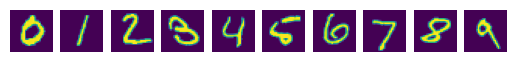

In [17]:
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets)

## Split layer = 2

Without noise:

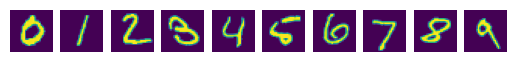

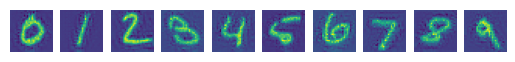

In [31]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise:

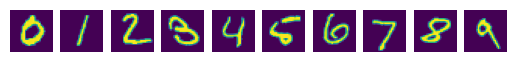

In [19]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

# Split layer = 3

 Without noise

In [20]:
split_layer = 3

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.301586866378784 Acc: 9.90695128626163
Epoch: 1 Loss: 2.2995126247406006 Acc: 9.833333333333334
Epoch: 2 Loss: 2.297455072402954 Acc: 10.326086956521738
Epoch: 3 Loss: 2.295138120651245 Acc: 14.810751508502468
Epoch: 4 Loss: 2.2923223972320557 Acc: 21.696035242290748
Epoch: 5 Loss: 2.2885243892669678 Acc: 22.84931506849315
Epoch: 6 Loss: 2.2830047607421875 Acc: 30.03865267807841
Epoch: 7 Loss: 2.2741918563842773 Acc: 33.205479452054796
Epoch: 8 Loss: 2.2573423385620117 Acc: 36.013215859030836
Epoch: 9 Loss: 2.220493793487549 Acc: 38.71499176276771
Epoch: 10 Loss: 2.1122844219207764 Acc: 44.6831955922865
Epoch: 11 Loss: 1.754472017288208 Acc: 67.7753544165758
Epoch: 12 Loss: 1.1128756999969482 Acc: 77.77777777777777
Epoch: 13 Loss: 0.6861169338226318 Acc: 82.75290215588723
Epoch: 14 Loss: 0.53402179479599 Acc: 85.97359735973598
Epoch: 15 Loss: 0.46232643723487854 Acc: 86.94459681843115
Epoch: 16 Loss: 0.4163520336151123 Acc: 89.04709748083242
Epoch: 17 Loss: 0.3814432322

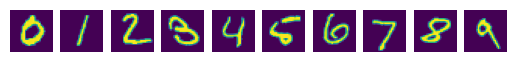

In [21]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

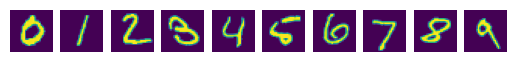

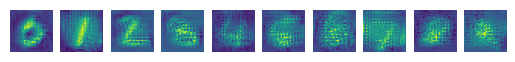

In [22]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise

In [23]:
split_layer = 3

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.3013031482696533 Acc: 11.588683351468989
Epoch: 1 Loss: 2.299302816390991 Acc: 14.967462039045554
Epoch: 2 Loss: 2.2972981929779053 Acc: 12.280701754385966
Epoch: 3 Loss: 2.2949485778808594 Acc: 13.713658804168952
Epoch: 4 Loss: 2.291714906692505 Acc: 15.452054794520548
Epoch: 5 Loss: 2.2870705127716064 Acc: 21.147540983606557
Epoch: 6 Loss: 2.2805113792419434 Acc: 25.625680087051144
Epoch: 7 Loss: 2.269629716873169 Acc: 28.726877040261154
Epoch: 8 Loss: 2.2481606006622314 Acc: 42.46053347849755
Epoch: 9 Loss: 2.200547456741333 Acc: 51.15384615384615
Epoch: 10 Loss: 2.0650076866149902 Acc: 56.1056105610561
Epoch: 11 Loss: 1.7064590454101562 Acc: 62.4390243902439
Epoch: 12 Loss: 1.267823338508606 Acc: 73.18405243036592
Epoch: 13 Loss: 0.956246018409729 Acc: 79.13234486545853
Epoch: 14 Loss: 0.8176893591880798 Acc: 83.06849315068493
Epoch: 15 Loss: 0.714192271232605 Acc: 83.42420937840785
Epoch: 16 Loss: 0.6017169952392578 Acc: 87.75623268698061
Epoch: 17 Loss: 0.5499411

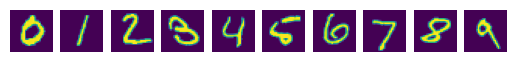

In [24]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

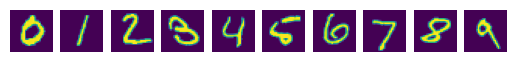

In [25]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

# Split layer = 4

 Without noise

In [4]:
split_layer = 4

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.3034186363220215 Acc: 9.735973597359736
Epoch: 1 Loss: 2.298372983932495 Acc: 13.091309130913091
Epoch: 2 Loss: 2.2930209636688232 Acc: 14.387699066447007
Epoch: 3 Loss: 2.286285638809204 Acc: 16.11479028697572
Epoch: 4 Loss: 2.2760510444641113 Acc: 23.448654585392642
Epoch: 5 Loss: 2.2566633224487305 Acc: 35.07625272331155
Epoch: 6 Loss: 2.2110745906829834 Acc: 35.12623490669594
Epoch: 7 Loss: 2.0711209774017334 Acc: 41.88453159041394
Epoch: 8 Loss: 1.6919783353805542 Acc: 68.56039713182571
Epoch: 9 Loss: 1.0722484588623047 Acc: 77.67416346681294
Epoch: 10 Loss: 0.6943076848983765 Acc: 80.83604777415853
Epoch: 11 Loss: 0.5629660487174988 Acc: 83.67234744365035
Epoch: 12 Loss: 0.4922640919685364 Acc: 86.76872607982504
Epoch: 13 Loss: 0.4426325857639313 Acc: 88.05723720418271
Epoch: 14 Loss: 0.4045231342315674 Acc: 88.79168944778567
Epoch: 15 Loss: 0.37444692850112915 Acc: 87.93668122270742
Epoch: 16 Loss: 0.34854140877723694 Acc: 89.18623702894592
Epoch: 17 Loss: 0.326

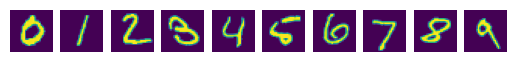

In [5]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

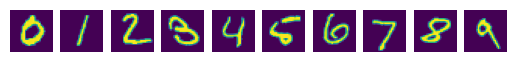

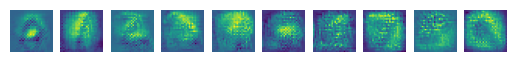

In [6]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise

In [71]:
split_layer = 4

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

/tmp/ipykernel_1382693/3143060372.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = nn.Parameter(torch.tensor(std))


Epoch: 0 Loss: 0.435196191072464 Acc: 96.51984774333877
Epoch: 1 Loss: 0.09415820986032486 Acc: 98.30693610049154
Epoch: 2 Loss: 0.06612655520439148 Acc: 98.19573537452159
Epoch: 3 Loss: 0.05197468400001526 Acc: 98.80174291938998
Epoch: 4 Loss: 0.041448380798101425 Acc: 98.180815876516


/tmp/ipykernel_1382693/3143060372.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = nn.Parameter(torch.tensor(std))


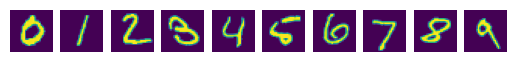

In [72]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

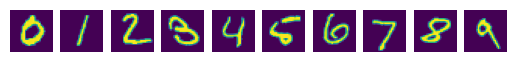

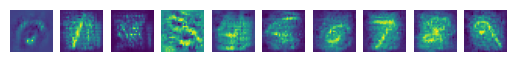

In [73]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=10, model_iters=10)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

# Split layer = 5

Without noise

In [26]:
split_layer = 5

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.301816463470459 Acc: 13.986784140969164
Epoch: 1 Loss: 2.299138307571411 Acc: 18.9873417721519
Epoch: 2 Loss: 2.2961647510528564 Acc: 12.947658402203857
Epoch: 3 Loss: 2.2926130294799805 Acc: 15.997830802603037
Epoch: 4 Loss: 2.288026809692383 Acc: 16.70305676855895
Epoch: 5 Loss: 2.281747817993164 Acc: 20.89227421109902
Epoch: 6 Loss: 2.272207736968994 Acc: 28.579205225911814
Epoch: 7 Loss: 2.2557127475738525 Acc: 46.191512513601744
Epoch: 8 Loss: 2.221323013305664 Acc: 58.624454148471614
Epoch: 9 Loss: 2.123505115509033 Acc: 59.584926269797926
Epoch: 10 Loss: 1.7473639249801636 Acc: 73.42888643880926
Epoch: 11 Loss: 1.0028183460235596 Acc: 82.3529411764706
Epoch: 12 Loss: 0.6249386668205261 Acc: 86.56061437191443
Epoch: 13 Loss: 0.4976007640361786 Acc: 88.1412024269167
Epoch: 14 Loss: 0.43025779724121094 Acc: 87.66901027582477
Epoch: 15 Loss: 0.38460302352905273 Acc: 90.633608815427
Epoch: 16 Loss: 0.3504764139652252 Acc: 90.73972602739725
Epoch: 17 Loss: 0.323334306

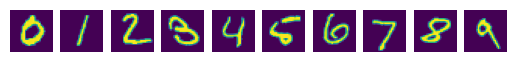

In [27]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

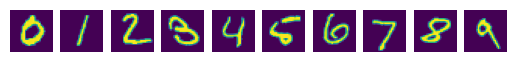

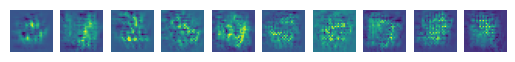

In [28]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise

In [29]:
split_layer = 5

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.3039462566375732 Acc: 7.666850523993381
Epoch: 1 Loss: 2.301337242126465 Acc: 10.391730141458106
Epoch: 2 Loss: 2.2990784645080566 Acc: 10.45104510451045
Epoch: 3 Loss: 2.296475648880005 Acc: 9.195402298850574
Epoch: 4 Loss: 2.293565034866333 Acc: 22.07009857612267
Epoch: 5 Loss: 2.290058135986328 Acc: 26.260964912280702
Epoch: 6 Loss: 2.285613775253296 Acc: 25.151682294539437
Epoch: 7 Loss: 2.2788915634155273 Acc: 30.7608100711549
Epoch: 8 Loss: 2.2682459354400635 Acc: 36.76633444075305
Epoch: 9 Loss: 2.2496731281280518 Acc: 43.48302300109529
Epoch: 10 Loss: 2.2103312015533447 Acc: 49.58993985784582
Epoch: 11 Loss: 2.1059377193450928 Acc: 50.57408419901586
Epoch: 12 Loss: 1.8044158220291138 Acc: 57.766721945826426
Epoch: 13 Loss: 1.3367106914520264 Acc: 69.22657952069717
Epoch: 14 Loss: 0.9790579676628113 Acc: 75.1360174102285
Epoch: 15 Loss: 0.7697248458862305 Acc: 78.05145046524356
Epoch: 16 Loss: 0.6329357028007507 Acc: 84.15570175438596
Epoch: 17 Loss: 0.535920560

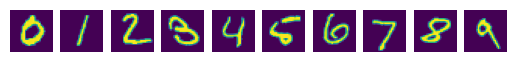

In [30]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

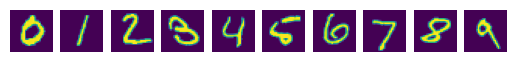

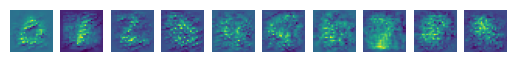

In [31]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

# Split layer = 6

Without noise

In [32]:
split_layer = 6

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.302985906600952 Acc: 9.718387631143015
Epoch: 1 Loss: 2.3008248805999756 Acc: 9.835164835164836
Epoch: 2 Loss: 2.2986984252929688 Acc: 10.425764192139738
Epoch: 3 Loss: 2.2963531017303467 Acc: 12.389380530973451
Epoch: 4 Loss: 2.2935068607330322 Acc: 11.400651465798045
Epoch: 5 Loss: 2.2897214889526367 Acc: 11.735537190082646
Epoch: 6 Loss: 2.2842800617218018 Acc: 15.858310626702997
Epoch: 7 Loss: 2.2756805419921875 Acc: 20.708446866485012
Epoch: 8 Loss: 2.260310411453247 Acc: 38.48268279274327
Epoch: 9 Loss: 2.226755380630493 Acc: 47.26670347874103
Epoch: 10 Loss: 2.123117685317993 Acc: 53.06345733041576
Epoch: 11 Loss: 1.7188565731048584 Acc: 67.8688524590164
Epoch: 12 Loss: 0.9857895374298096 Acc: 80.21798365122616
Epoch: 13 Loss: 0.6297323107719421 Acc: 86.1974904528096
Epoch: 14 Loss: 0.5065602660179138 Acc: 87.77412280701755
Epoch: 15 Loss: 0.4439259171485901 Acc: 88.32599118942731
Epoch: 16 Loss: 0.40186038613319397 Acc: 89.18770581778266
Epoch: 17 Loss: 0.36992

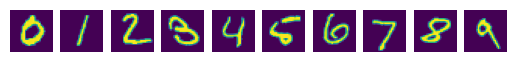

In [33]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

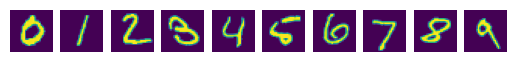

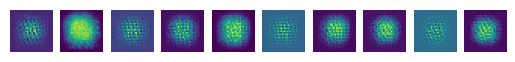

In [34]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise

In [61]:
split_layer = 6

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

/tmp/ipykernel_1382693/3143060372.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = nn.Parameter(torch.tensor(std))


Epoch: 0 Loss: 0.337476521730423 Acc: 97.6884975233902
Epoch: 1 Loss: 0.08331463485956192 Acc: 98.3032293377121
Epoch: 2 Loss: 0.05886216089129448 Acc: 98.27968923418425
Epoch: 3 Loss: 0.046588823199272156 Acc: 98.35345773874863
Epoch: 4 Loss: 0.04089482128620148 Acc: 98.51811196487377


/tmp/ipykernel_1382693/3143060372.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = nn.Parameter(torch.tensor(std))


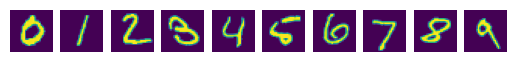

In [62]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

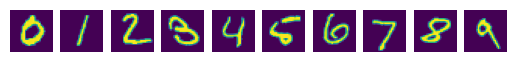

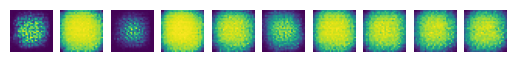

In [63]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=10, model_iters=10)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## Cut layer 1

# Without noise

In [64]:
split_layer = 1

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.2983405590057373 Acc: 96.88013136288998
Epoch: 1 Loss: 0.08255693316459656 Acc: 98.57534246575342
Epoch: 2 Loss: 0.05839382857084274 Acc: 98.73556899395273
Epoch: 3 Loss: 0.045414865016937256 Acc: 98.70689655172414
Epoch: 4 Loss: 0.03759968653321266 Acc: 98.34345665378244


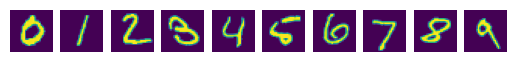

In [65]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

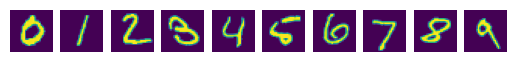

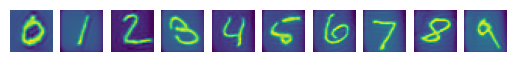

In [66]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=10, model_iters=10)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## With noise

In [67]:
split_layer = 1

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

/tmp/ipykernel_1382693/3143060372.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = nn.Parameter(torch.tensor(std))


Epoch: 0 Loss: 0.3816273510456085 Acc: 97.63346175013758
Epoch: 1 Loss: 0.08351271599531174 Acc: 98.2532751091703
Epoch: 2 Loss: 0.05852925777435303 Acc: 98.73556899395273
Epoch: 3 Loss: 0.045970749109983444 Acc: 98.35706462212487
Epoch: 4 Loss: 0.038424957543611526 Acc: 98.56749311294766


/tmp/ipykernel_1382693/3143060372.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = nn.Parameter(torch.tensor(std))


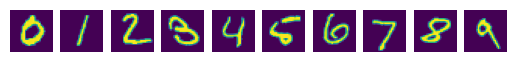

In [68]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

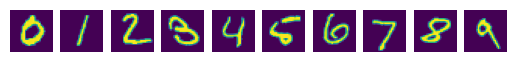

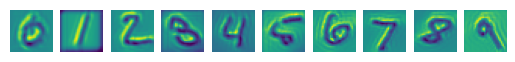

In [69]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=10, model_iters=10)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

### Fashion-MNIST

# Cut layer 2

Without noise

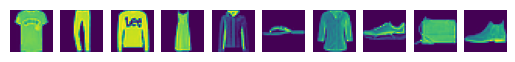

In [6]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

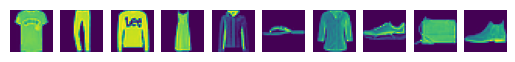

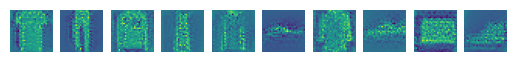

In [7]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise

In [11]:
split_layer = 2

dataset = 'f_mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.7772446870803833 Acc: 77.66776677667767
Epoch: 1 Loss: 0.48276427388191223 Acc: 83.99558498896248
Epoch: 2 Loss: 0.3993394076824188 Acc: 84.3353557639272
Epoch: 3 Loss: 0.3541116714477539 Acc: 86.63366336633663
Epoch: 4 Loss: 0.32647064328193665 Acc: 89.44201312910285
Epoch: 5 Loss: 0.307142049074173 Acc: 88.44665561083471
Epoch: 6 Loss: 0.29051274061203003 Acc: 88.26784726065301
Epoch: 7 Loss: 0.2749636769294739 Acc: 88.70523415977961
Epoch: 8 Loss: 0.26363006234169006 Acc: 88.59023587493144
Epoch: 9 Loss: 0.2519347369670868 Acc: 88.78400888395336


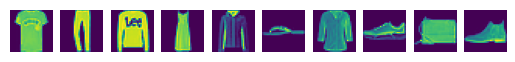

In [12]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

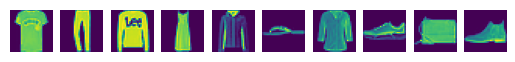

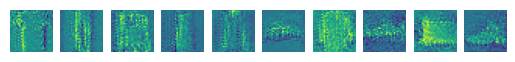

In [13]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

# Cut layer 3


## Without noise

In [6]:
split_layer = 3

dataset = 'f_mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.6633545160293579 Acc: 81.22959738846572
Epoch: 1 Loss: 0.42736706137657166 Acc: 84.08590308370044
Epoch: 2 Loss: 0.3627222776412964 Acc: 86.8995633187773
Epoch: 3 Loss: 0.3233981728553772 Acc: 87.94716565767749
Epoch: 4 Loss: 0.30055293440818787 Acc: 88.64509051014811
Epoch: 5 Loss: 0.2822857201099396 Acc: 88.89499725123694
Epoch: 6 Loss: 0.2683640718460083 Acc: 88.44026548672566
Epoch: 7 Loss: 0.2561694383621216 Acc: 89.13282107574095
Epoch: 8 Loss: 0.24620214104652405 Acc: 88.76221498371335
Epoch: 9 Loss: 0.23599164187908173 Acc: 89.11268372346217


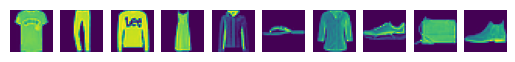

In [7]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

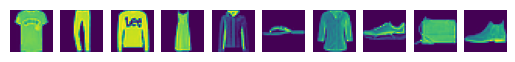

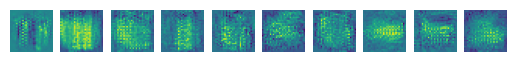

In [8]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise

In [9]:
split_layer = 3

dataset = 'f_mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.8576862812042236 Acc: 79.62962962962963
Epoch: 1 Loss: 0.48353853821754456 Acc: 81.46739130434783
Epoch: 2 Loss: 0.401150643825531 Acc: 86.73139158576052
Epoch: 3 Loss: 0.3546132743358612 Acc: 86.3036303630363
Epoch: 4 Loss: 0.323960542678833 Acc: 87.97156916347731
Epoch: 5 Loss: 0.3032243549823761 Acc: 86.35616438356165
Epoch: 6 Loss: 0.2847035825252533 Acc: 87.87878787878788
Epoch: 7 Loss: 0.27139943838119507 Acc: 89.66279712548369
Epoch: 8 Loss: 0.25956541299819946 Acc: 86.94702348443474
Epoch: 9 Loss: 0.24678859114646912 Acc: 90.07675438596492


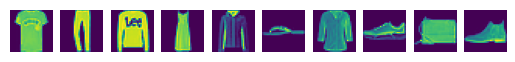

In [10]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

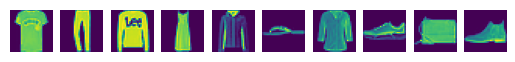

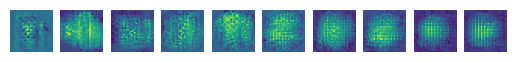

In [11]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

# Cut layer = 4

## Without noise

In [12]:
split_layer = 4

dataset = 'f_mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.6659717559814453 Acc: 82.42059145673603
Epoch: 1 Loss: 0.4280257225036621 Acc: 84.9254555494202
Epoch: 2 Loss: 0.3712977170944214 Acc: 87.96041781198461
Epoch: 3 Loss: 0.3319142460823059 Acc: 87.08264915161467
Epoch: 4 Loss: 0.3091796636581421 Acc: 89.28373126041089
Epoch: 5 Loss: 0.2938186526298523 Acc: 87.43828853538123
Epoch: 6 Loss: 0.2763725817203522 Acc: 88.4297520661157
Epoch: 7 Loss: 0.2665589451789856 Acc: 88.28039430449068
Epoch: 8 Loss: 0.25374698638916016 Acc: 89.11000552791597
Epoch: 9 Loss: 0.2429760992527008 Acc: 88.23529411764706


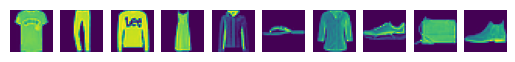

In [13]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

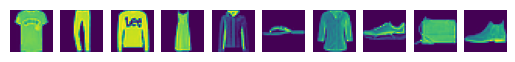

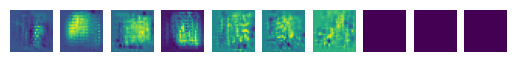

In [14]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## With noise

In [15]:
split_layer = 4

dataset = 'f_mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.7826366424560547 Acc: 75.70960698689956
Epoch: 1 Loss: 0.4670235812664032 Acc: 82.29223248234655
Epoch: 2 Loss: 0.3901423513889313 Acc: 86.56387665198238
Epoch: 3 Loss: 0.34701868891716003 Acc: 87.24573941726223
Epoch: 4 Loss: 0.3209589123725891 Acc: 86.42111050027488
Epoch: 5 Loss: 0.29944494366645813 Acc: 89.01098901098901
Epoch: 6 Loss: 0.2853793203830719 Acc: 88.0
Epoch: 7 Loss: 0.27065372467041016 Acc: 89.69631236442517
Epoch: 8 Loss: 0.25643426179885864 Acc: 88.40021990104454
Epoch: 9 Loss: 0.24443340301513672 Acc: 89.98357963875205


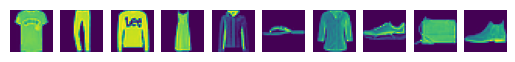

In [16]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

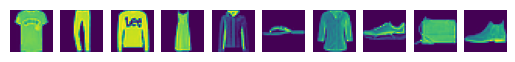

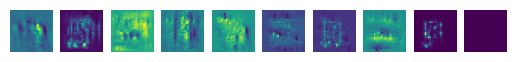

In [17]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

# Cut layer 5

## Without noise

In [18]:
split_layer = 5

dataset = 'f_mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.709888756275177 Acc: 79.42636514065086
Epoch: 1 Loss: 0.45997166633605957 Acc: 83.8586956521739
Epoch: 2 Loss: 0.39488136768341064 Acc: 84.98908296943232
Epoch: 3 Loss: 0.3509082496166229 Acc: 87.63056624518967
Epoch: 4 Loss: 0.32771584391593933 Acc: 88.89502762430939
Epoch: 5 Loss: 0.30472370982170105 Acc: 87.71444382955174
Epoch: 6 Loss: 0.2906287610530853 Acc: 87.91689447785676
Epoch: 7 Loss: 0.27704179286956787 Acc: 89.41885964912281
Epoch: 8 Loss: 0.2637946903705597 Acc: 89.90725586470268
Epoch: 9 Loss: 0.2518608272075653 Acc: 88.91951488423373


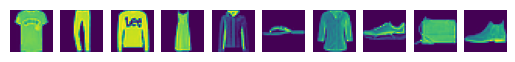

In [19]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

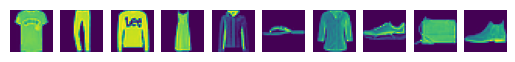

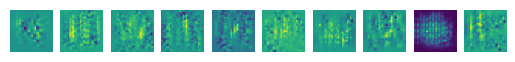

In [20]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## With  noise

In [21]:
split_layer = 5

dataset = 'f_mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.8591053485870361 Acc: 79.13472070098577
Epoch: 1 Loss: 0.5115107893943787 Acc: 83.43456653782441
Epoch: 2 Loss: 0.42554113268852234 Acc: 85.57377049180327
Epoch: 3 Loss: 0.3730998635292053 Acc: 85.43849972421401
Epoch: 4 Loss: 0.3395034670829773 Acc: 85.82333696837513
Epoch: 5 Loss: 0.31825873255729675 Acc: 88.14489571899011
Epoch: 6 Loss: 0.3021928668022156 Acc: 88.12636165577342
Epoch: 7 Loss: 0.28576555848121643 Acc: 87.00221238938053
Epoch: 8 Loss: 0.2727685570716858 Acc: 88.7114537444934
Epoch: 9 Loss: 0.26295205950737 Acc: 87.6101321585903


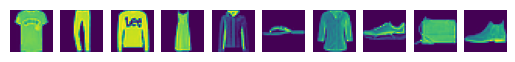

In [22]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

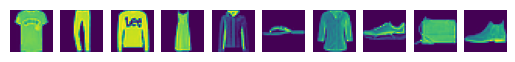

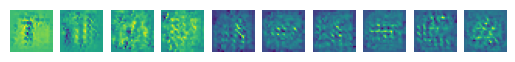

In [23]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

# Cut layer 6

## Without noise

In [24]:
split_layer = 6

dataset = 'f_mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.7183356285095215 Acc: 80.02189381499727
Epoch: 1 Loss: 0.4585535228252411 Acc: 84.32343234323433
Epoch: 2 Loss: 0.3948403298854828 Acc: 86.13698630136986
Epoch: 3 Loss: 0.3532683253288269 Acc: 88.17733990147784
Epoch: 4 Loss: 0.32866546511650085 Acc: 87.29641693811075
Epoch: 5 Loss: 0.307018518447876 Acc: 89.14348063284234
Epoch: 6 Loss: 0.2897597551345825 Acc: 87.5896304467733
Epoch: 7 Loss: 0.2758345603942871 Acc: 87.71349862258953
Epoch: 8 Loss: 0.262514591217041 Acc: 90.04920721705851
Epoch: 9 Loss: 0.25057539343833923 Acc: 87.87547788093937


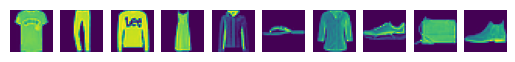

In [25]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

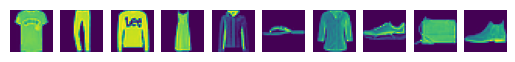

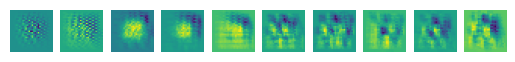

In [26]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## With noise

In [27]:
split_layer = 6

dataset = 'f_mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.7693580985069275 Acc: 78.62298722931705
Epoch: 1 Loss: 0.46857234835624695 Acc: 84.94505494505495
Epoch: 2 Loss: 0.39726853370666504 Acc: 84.71687740516768
Epoch: 3 Loss: 0.35565587878227234 Acc: 86.53739612188366
Epoch: 4 Loss: 0.3289529085159302 Acc: 86.08219178082192
Epoch: 5 Loss: 0.3097752034664154 Acc: 87.4037403740374
Epoch: 6 Loss: 0.29407304525375366 Acc: 87.32629238465815
Epoch: 7 Loss: 0.28130149841308594 Acc: 87.36323851203501
Epoch: 8 Loss: 0.26591363549232483 Acc: 89.07700709994539
Epoch: 9 Loss: 0.2583226263523102 Acc: 89.44474986256185


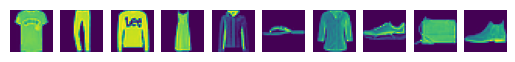

In [28]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

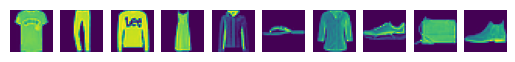

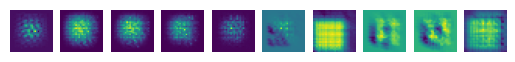

In [29]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

# Cut layer = 1

Without noise

In [41]:
split_layer = 1

dataset = 'f_mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.7109191417694092 Acc: 79.50413223140495
Epoch: 1 Loss: 0.4795001447200775 Acc: 84.74204171240395
Epoch: 2 Loss: 0.4011944532394409 Acc: 84.4676180021954
Epoch: 3 Loss: 0.36006587743759155 Acc: 86.44346871569704
Epoch: 4 Loss: 0.3302696943283081 Acc: 88.06787082649151
Epoch: 5 Loss: 0.31222546100616455 Acc: 86.29385964912281
Epoch: 6 Loss: 0.2934356927871704 Acc: 89.46791003839824
Epoch: 7 Loss: 0.27973508834838867 Acc: 89.157952669235
Epoch: 8 Loss: 0.26590827107429504 Acc: 89.2502756339581
Epoch: 9 Loss: 0.25249969959259033 Acc: 89.61325966850829


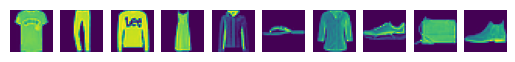

In [42]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

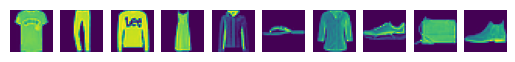

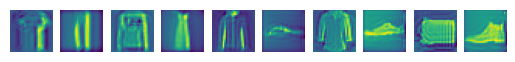

In [43]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=10, model_iters=10)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## With noise

In [50]:
split_layer = 1

dataset = 'f_mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

/tmp/ipykernel_1382693/3143060372.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = nn.Parameter(torch.tensor(std))


Epoch: 0 Loss: 0.913234531879425 Acc: 77.58904109589041
Epoch: 1 Loss: 0.5135990381240845 Acc: 84.03269754768392
Epoch: 2 Loss: 0.42189887166023254 Acc: 84.29661941112323
Epoch: 3 Loss: 0.37429165840148926 Acc: 87.11453744493392
Epoch: 4 Loss: 0.3449879288673401 Acc: 87.23519826181423
Epoch: 5 Loss: 0.3627326488494873 Acc: 88.18984547461369
Epoch: 6 Loss: 0.30404695868492126 Acc: 88.35429196282121
Epoch: 7 Loss: 0.2919221520423889 Acc: 87.78751369112815
Epoch: 8 Loss: 0.28338131308555603 Acc: 89.07887479316051
Epoch: 9 Loss: 0.270740270614624 Acc: 89.38486663037561


/tmp/ipykernel_1382693/3143060372.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = nn.Parameter(torch.tensor(std))


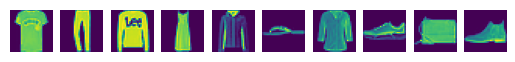

In [51]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

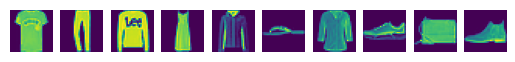

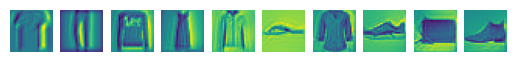

In [52]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=10, model_iters=10)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

### CIFAR

In [47]:
import torchvision.utils

Cut layer 2


In [3]:
split_layer = 2

dataset = 'cifar'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 Loss: 1.6317476034164429 Acc: 51.30151843817787
Epoch: 1 Loss: 1.1370787620544434 Acc: 63.013698630136986
Epoch: 2 Loss: 0.9034222960472107 Acc: 70.67545304777595
Epoch: 3 Loss: 0.7422498464584351 Acc: 71.25748502994011
Epoch: 4 Loss: 0.6272610425949097 Acc: 74.34065934065934


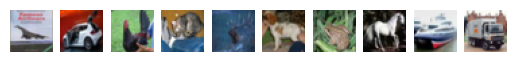

In [4]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_cifar(inversion_targets)

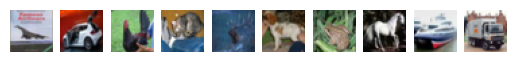

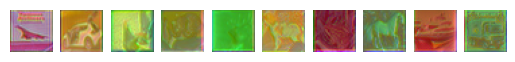

In [7]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=50, model_iters=50)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise

In [80]:
sigma = 0.25

In [10]:
split_layer = 2

dataset = 'cifar'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 Loss: 1.793684482574463 Acc: 47.89041095890411
Epoch: 1 Loss: 1.3162519931793213 Acc: 55.89374654122856
Epoch: 2 Loss: 1.062522053718567 Acc: 66.00660066006601
Epoch: 3 Loss: 0.8665772080421448 Acc: 68.91817682591983
Epoch: 4 Loss: 0.7329316735267639 Acc: 69.26882902693788


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


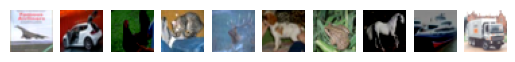

In [11]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_cifar(noised_inversion_targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


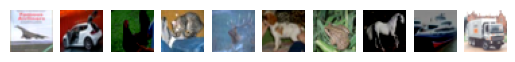

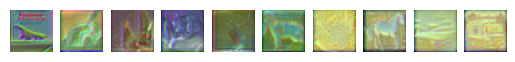

In [12]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=10, model_iters=10)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## Cut layer 3

In [75]:
split_layer = 3

dataset = 'cifar'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 Loss: 1.7013630867004395 Acc: 47.728516694033935
Epoch: 1 Loss: 1.254276990890503 Acc: 59.010989010989015
Epoch: 2 Loss: 1.0308337211608887 Acc: 63.025669033315125
Epoch: 3 Loss: 0.8609066605567932 Acc: 68.90478811227298
Epoch: 4 Loss: 0.7321578860282898 Acc: 71.34986225895317


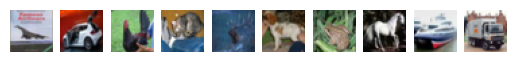

In [76]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_cifar(inversion_targets)

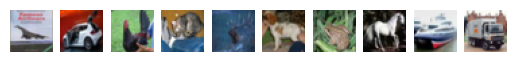

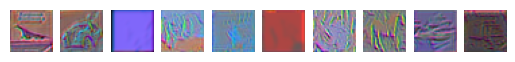

In [78]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=10, model_iters=10)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

In [74]:
sigma

tensor(1.5735)

## With noise

In [81]:
split_layer = 3

dataset = 'cifar'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 Loss: 1.7867765426635742 Acc: 49.14975315414153
Epoch: 1 Loss: 1.2581732273101807 Acc: 60.88621444201313
Epoch: 2 Loss: 0.9733221530914307 Acc: 66.04498080087767
Epoch: 3 Loss: 0.8068504929542542 Acc: 70.62396466040862
Epoch: 4 Loss: 0.6743704080581665 Acc: 71.38949671772428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


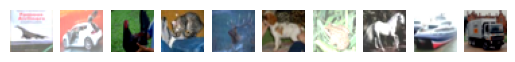

In [82]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_cifar(noised_inversion_targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


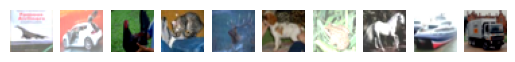

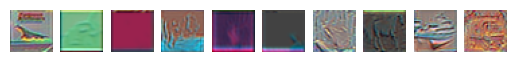

In [83]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=10, model_iters=10)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## Cut layer 4

### Without noise

In [17]:
split_layer = 4

dataset = 'cifar'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 Loss: 1.5691282749176025 Acc: 54.71594043022615
Epoch: 1 Loss: 1.1071650981903076 Acc: 65.93527153044433
Epoch: 2 Loss: 0.8782371878623962 Acc: 67.76135741652983
Epoch: 3 Loss: 0.7228598594665527 Acc: 74.44933920704845
Epoch: 4 Loss: 0.5957238078117371 Acc: 73.62030905077263


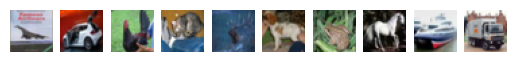

In [18]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_cifar(inversion_targets)

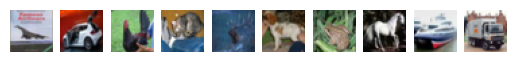

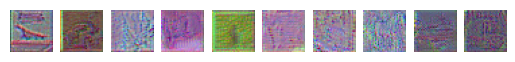

In [19]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=50, model_iters=50)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## With noise

In [20]:
split_layer = 4

dataset = 'cifar'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 Loss: 1.76051926612854 Acc: 46.4873765093304
Epoch: 1 Loss: 1.2838070392608643 Acc: 60.89813800657174
Epoch: 2 Loss: 1.0108999013900757 Acc: 66.51958080529509
Epoch: 3 Loss: 0.8113706707954407 Acc: 68.04407713498622
Epoch: 4 Loss: 0.6770601272583008 Acc: 73.71303395399781


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


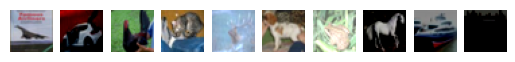

In [21]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_cifar(noised_inversion_targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


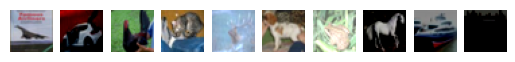

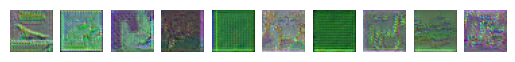

In [22]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=10, model_iters=10)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## Cut layer = 5

## Without noise

In [23]:
split_layer = 5

dataset = 'cifar'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 Loss: 1.6441680192947388 Acc: 53.3003300330033
Epoch: 1 Loss: 1.1530710458755493 Acc: 62.8085573230938
Epoch: 2 Loss: 0.9067559242248535 Acc: 68.12154696132596
Epoch: 3 Loss: 0.7630254626274109 Acc: 70.26878771256172
Epoch: 4 Loss: 0.6602967977523804 Acc: 72.5108225108225


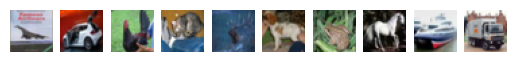

In [24]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_cifar(inversion_targets)

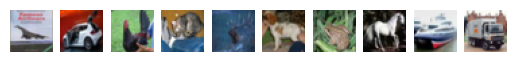

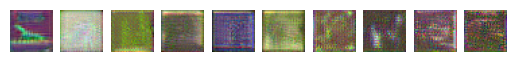

In [25]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=50, model_iters=50)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## With noise

In [26]:
split_layer = 5

dataset = 'cifar'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 Loss: 1.7088011503219604 Acc: 50.386313465783665
Epoch: 1 Loss: 1.224905252456665 Acc: 61.896929824561404
Epoch: 2 Loss: 0.9778026342391968 Acc: 67.70491803278688
Epoch: 3 Loss: 0.7996149659156799 Acc: 72.47252747252747
Epoch: 4 Loss: 0.6617618203163147 Acc: 70.68870523415978


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

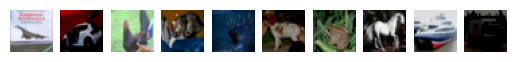

In [27]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_cifar(noised_inversion_targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

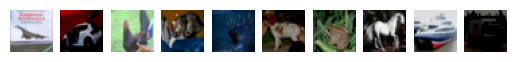

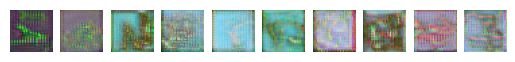

In [28]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=10, model_iters=10)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## Cut layer 6

## Without noise

In [29]:
split_layer = 6

dataset = 'cifar'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 Loss: 1.6135284900665283 Acc: 51.05204872646733
Epoch: 1 Loss: 1.1463369131088257 Acc: 65.16483516483517
Epoch: 2 Loss: 0.9312132000923157 Acc: 69.32314410480349
Epoch: 3 Loss: 0.7881666421890259 Acc: 71.46042363433668
Epoch: 4 Loss: 0.6663190722465515 Acc: 71.51448879168944


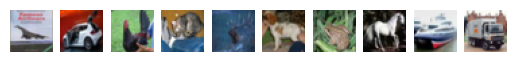

In [30]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_cifar(inversion_targets)

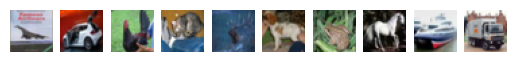

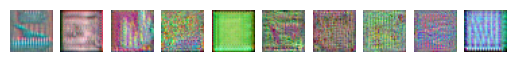

In [31]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=50, model_iters=50)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## With noise

In [32]:
split_layer = 6

dataset = 'cifar'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 Loss: 1.8128812313079834 Acc: 46.34414513468939
Epoch: 1 Loss: 1.3179835081100464 Acc: 54.66957946477335
Epoch: 2 Loss: 1.0644887685775757 Acc: 65.7080846446012
Epoch: 3 Loss: 0.8748601078987122 Acc: 70.14270032930845
Epoch: 4 Loss: 0.7434958815574646 Acc: 71.63120567375887


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


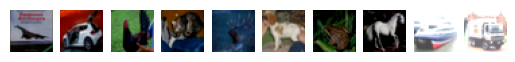

In [33]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_cifar(noised_inversion_targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


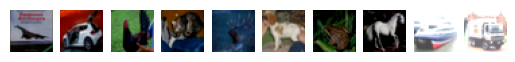

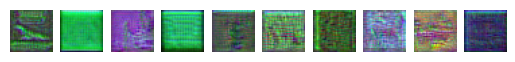

In [34]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=10, model_iters=10)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## Cut layer 1

## Without noise

In [35]:
split_layer = 1

dataset = 'cifar'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 Loss: 1.6581969261169434 Acc: 52.16201423097975
Epoch: 1 Loss: 1.1415413618087769 Acc: 61.42857142857143
Epoch: 2 Loss: 0.917607843875885 Acc: 67.76677667766776
Epoch: 3 Loss: 0.7642976641654968 Acc: 73.28579264947888
Epoch: 4 Loss: 0.6461603045463562 Acc: 73.52620087336244


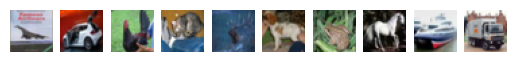

In [36]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_cifar(inversion_targets)

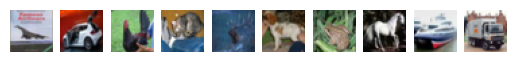

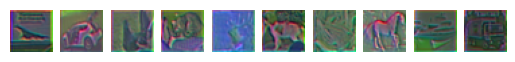

In [37]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=50, model_iters=50)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

## With noise

In [38]:
split_layer = 1

dataset = 'cifar'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.Adam(client.parameters(), lr=0.001)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 Loss: 1.8130722045898438 Acc: 47.50271444082519
Epoch: 1 Loss: 1.3583049774169922 Acc: 54.91047205642973
Epoch: 2 Loss: 1.1157655715942383 Acc: 63.30777656078861
Epoch: 3 Loss: 0.9213413000106812 Acc: 69.97245179063361
Epoch: 4 Loss: 0.780709981918335 Acc: 69.53168044077135


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


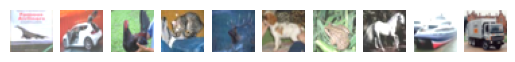

In [39]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_cifar(noised_inversion_targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


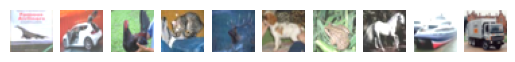

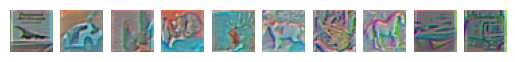

In [40]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=100, input_iters=10, model_iters=10)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)